<a href="https://colab.research.google.com/github/Arevalinchy/Image_Processing_Initiative/blob/main/IIPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Image Processing Proyect
## By Santiago Arevalo

Objective: To use disparity maps from stereoscopic images to improve the segmentation of these image 

In [1]:
!pip install opencv-python

/usr/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point


In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

# Part 1

The first step consists in computing the disparity map itself

Disparity map: Is an image where its pixel has a value corresponding to the displacements of pixels from one image to the other on stereo images

Algorithm idea:
for each pixel of the image corresponding to the left eye (left image) 
find the corresponding pixel in the right image 
  
put the corresponding distance (displacement value) in the corresponding pixel of the map


The main problem is: how to put in correspondance pixels of two different images ?



## Making the stereoscopic image

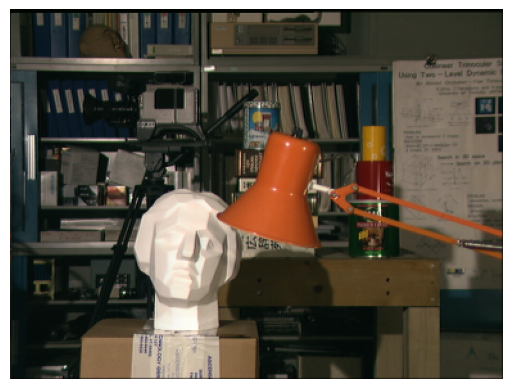

In [3]:
#we upload the image with the left side and right side 
img = cv.imread('img/TsukabaL.png')
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [4]:
#taking the two stereocopic images
#Due to being matrices is simle to grab Regions Of Interes by giving the coordinates 
#imgL = img[100:500,0:550] 
#imgR = img[100:500,550:1100]

imgL = cv.imread('img/TsukabaL.png')
imgR = cv.imread('img/TsukabaR.png')
 

In [5]:
def imgSizeCheck(img_left, img_right):
    return img_left.size == img_right.size

In [6]:
if not imgSizeCheck(imgL, imgR):
    imgL = cv.resize(imgL,(875,522),interpolation= cv.INTER_LINEAR) 
    imgR = cv.resize(imgR,(875,522),interpolation= cv.INTER_LINEAR) 

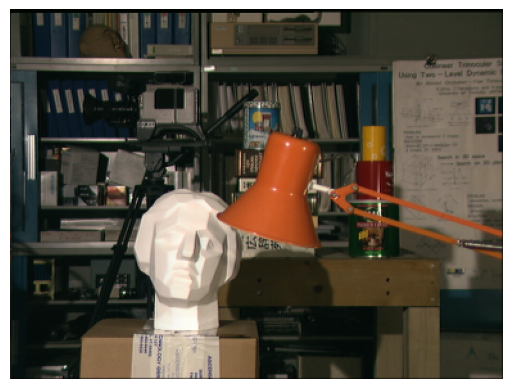

In [7]:
#Plotting the right one
plt.imshow(cv.cvtColor(imgL, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

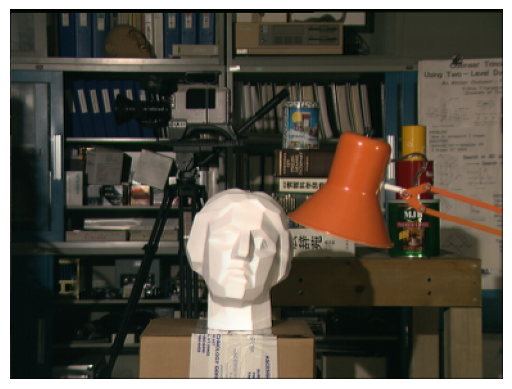

In [8]:
#Plotting the left one
plt.imshow(cv.cvtColor(imgR, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

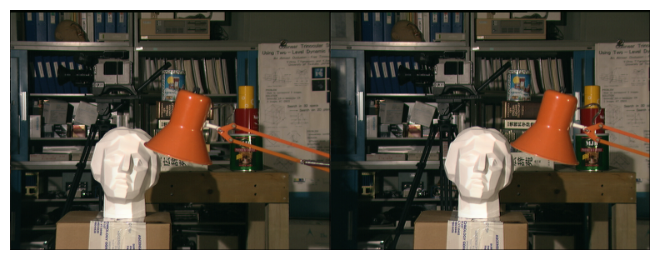

In [9]:
f = plt.figure()
f.add_subplot(1,2, 1,frameon=False)
plt.imshow(cv.cvtColor(imgL, cv.COLOR_BGR2RGB))
plt.axis('off')
f.add_subplot(1,2, 2,frameon=False)
plt.imshow(cv.cvtColor(imgR, cv.COLOR_BGR2RGB))
plt.axis('off')

plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()


## Making the red/Cyan image

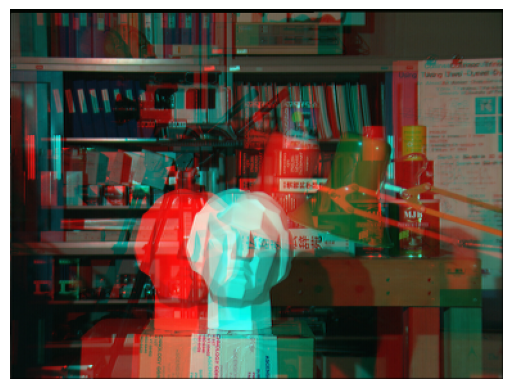

In [10]:
#We rip apart the color channels from the image
if(imgSizeCheck(imgL,imgR)):
    #Color channels for the left image
    (Bl_Channel,Gl_Channel,Rl_Channel) = cv.split(imgL)
    
    #Color channels for the right image
    (Br_Channel,Gr_Channel,Rr_Channel) = cv.split(imgR)
    
    #Even though we took all 3 channels from each image, we only need the red channel from 
    #the left image and the blue and green channel from the right one. 
    
    #now we make the Red/Cyan Analyph
    RCA = cv.merge((Br_Channel,Gr_Channel,Rl_Channel))#Functions take independent channels and creates a single image!
    plt.imshow(cv.cvtColor(RCA,cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print(f"Wrong size: left = {imgL.size} & right = {imgR.size}")



# Part 2

**Creating the disparity map**

The code bellow reveals disparity map for the two selected images. For the time being it looks in rough shape and not ideal at all

In [11]:
#imgL = cv.cvtColor(imgL,cv.COLOR_BGR2GRAY) 
#imgR = cv.cvtColor(imgR,cv.COLOR_BGR2GRAY)
imgL = cv.imread('img/tsukuba_l.png',0)
imgR = cv.imread('img/tsukuba_r.png',0)


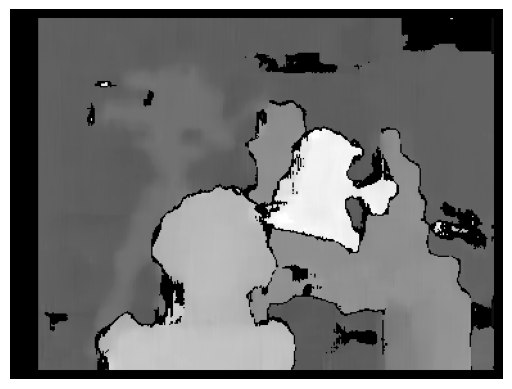

In [12]:
if(imgSizeCheck(imgL,imgR)):
    stereo = cv.StereoBM.create(numDisparities=16, blockSize=15)
    disparity = stereo.compute(imgL,imgR)
    plt.imshow(disparity,'gray')
    plt.axis('off')
    plt.show()
else:
     print(f"Wrong size: left = {imgL.size} & right = {imgR.size}")

Now we proceed to play with the other parameter functions to make the image better

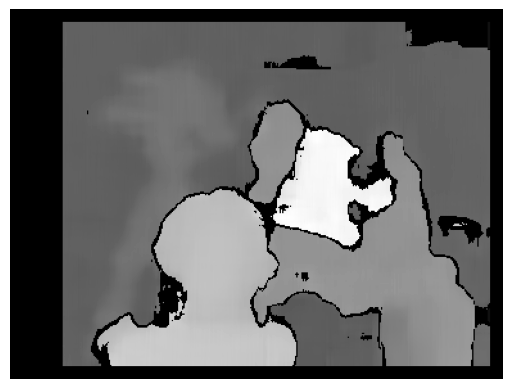

In [13]:
stereo = cv.StereoBM_create(numDisparities=32, blockSize=21)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.axis('off')
plt.show()

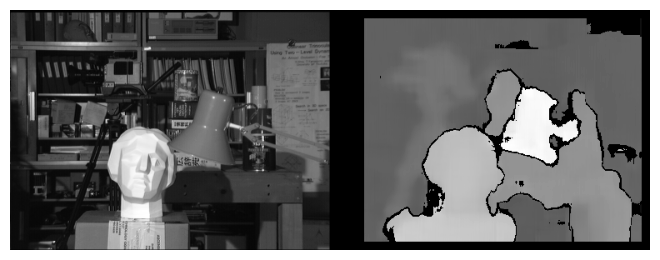

In [14]:
f = plt.figure()
f.add_subplot(1,2, 1,frameon=False)
plt.imshow(imgL,'gray')
plt.axis('off')
f.add_subplot(1,2, 2,frameon=False)
plt.imshow(disparity,'gray')
plt.axis('off')

plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()

# Part 3

Segmentation algorithms can be classified into three categories :
- pixel based algorithms, for example histogram-based ones.
- edge based algorithm (most of the time, it corresponds to high pass filters)
- region based algorithm (watershed, split and merge, etc.)

## K-Means

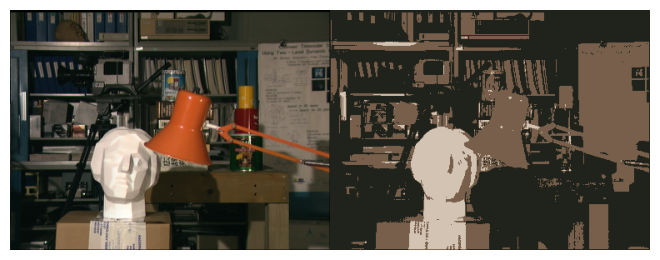

In [15]:
#Converting the image into HSV
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
#Converting the image from a MxNx3 to a Kx3
Vect = img.reshape((-1,3))
#transform into unit 8 parce que k-means dijo el hijo de prra!
Vect = np.float32(Vect)

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

K = 3
attempts = 10
ret, label, center = cv.kmeans(Vect, K, None, criteria, attempts, cv.KMEANS_PP_CENTERS)

center = np.uint8(center)

res = center[label.flatten()]
result_image = res.reshape((img.shape))

f = plt.figure()
f.add_subplot(1,2, 1,frameon=False)
plt.imshow(img,'gray')
plt.axis('off')
f.add_subplot(1,2, 2,frameon=False)
plt.imshow(result_image,'gray')
plt.axis('off')

plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()

## Pixel Based

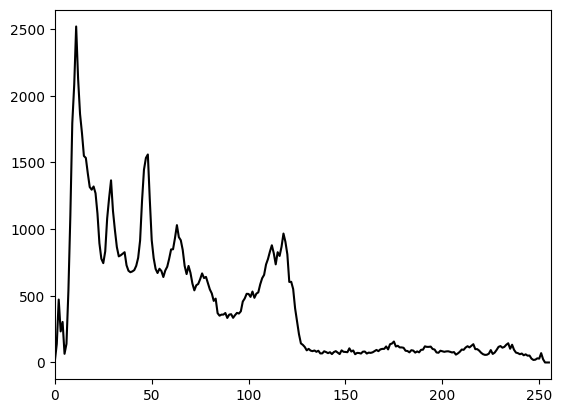

In [16]:
#As our pixel base method, we are going to use an histogram analysis.

#histogram method from open cv.
#It recives five arguments [img], [channel], mask, histSize = [bin], range = [0,256]
hist = cv.calcHist([imgL],channels = [0],mask = None, histSize = [256], ranges = [0,256])
#Now whe have the code for plotting the histogram
plt.plot(hist,color = "black")
plt.xlim([0,256])
plt.show()

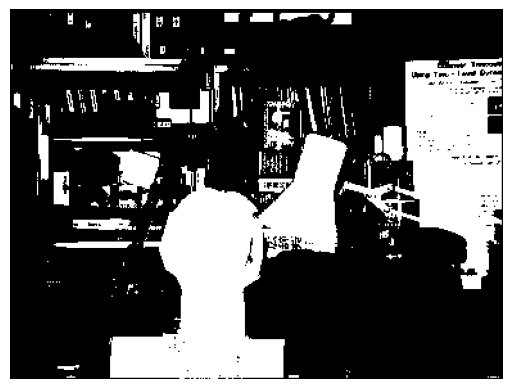

In [23]:
#Making the segmentation

#We create the foreground and the background regions
foreground = (imgL >= 90)
background = (imgL < 90)
#We make use of a zeroes matrix to build our new image, the segmented one.
segmentd_img = np.zeros((imgL.shape[0],imgL.shape[1],3))
segmentd_img[foreground ] = (1,1,1) #white in float
segmentd_img[background ] = (0,0,0) #black in float

#printing the image
plt.imshow(segmentd_img)
plt.axis('off')
plt.show()

## Edge Based

In [24]:
#Bluring the image
blrImg = cv.GaussianBlur(imgL, (3,3), sigmaX = 0, sigmaY = 0) 

#This is done in order to reduce the nosie of the image, preventing any mistakes in the edge detection

### Sobel

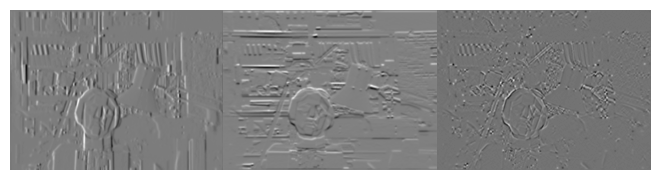

In [25]:
#implementig sobel
#Detects edges by following the sudden changes in pixel intensity. Derivatives are also use to find this changes.
#ddepth specifies the precition of the output image.
#dx & dy specify the order of the derivative in their respective directions. 
# dx = 1 & dy = 0 means we compute the sobel image only on the horizontal axis, showing the vertical axis

edge_sblx = cv.Sobel(src = blrImg, ddepth=cv.CV_64F, dx=1,dy=0,ksize=5)
edge_sbly = cv.Sobel(src = blrImg, ddepth=cv.CV_64F, dx=0,dy=1,ksize=5)
edge_sblxy = cv.Sobel(src = blrImg, ddepth=cv.CV_64F, dx=1,dy=1,ksize=5)


f = plt.figure()
f.add_subplot(1,3,1,frameon=False)
plt.imshow(edge_sblx,'gray')
plt.axis('off')
f.add_subplot(1,3,2,frameon=False)
plt.imshow(edge_sbly,'gray')
plt.axis('off')
f.add_subplot(1,3,3,frameon=False)
plt.imshow(edge_sblxy,'gray')
plt.axis('off')

plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()

### Canny

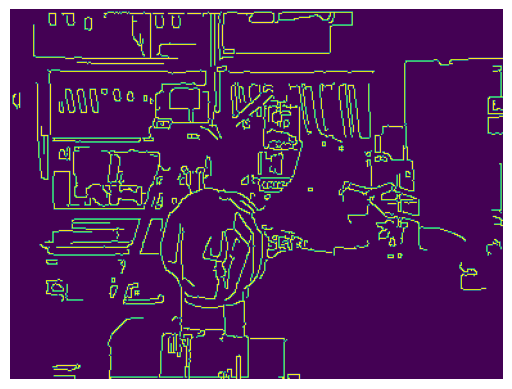

In [26]:
#Implementing Canny
#Detectes by the use of a gradient
edgeCanny = cv.Canny(image = blrImg, threshold1=100, threshold2=200)

plt.imshow(edgeCanny )
plt.axis('off')
plt.show()


## Region Based

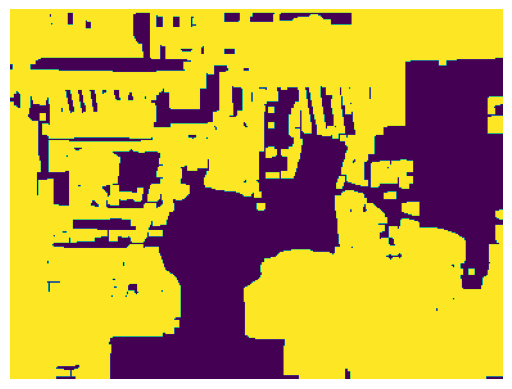

In [43]:
ret, bin_img = cv.threshold(imgL,
                             0, 255, 
                             cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
bin_image = cv.morphologyEx(bin_img, cv.MORPH_OPEN, kernel, iterations = 2)

#printing the image
plt.imshow(bin_image)
plt.axis('off')
plt.show()

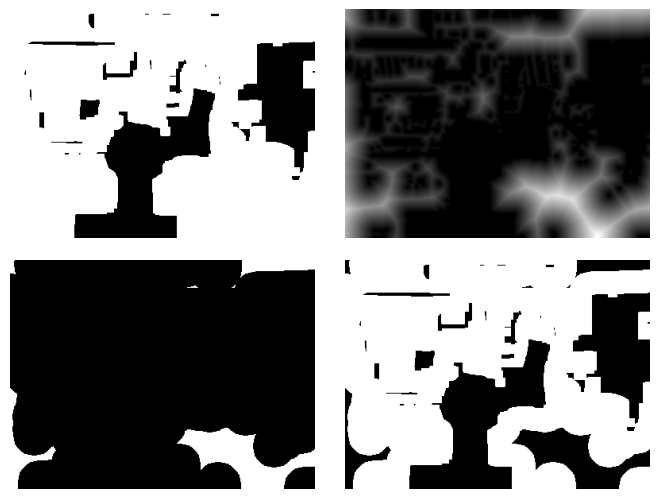

In [47]:
#Taking the background, the foreground, distance & the "unknown"

sure_bg = cv.dilate(bin_image, kernel, iterations=3)

#bin_image = np.uint8(bin_image)

dist = cv.distanceTransform(bin_image, cv.DIST_L2, 5)

ret, sure_fg = cv.threshold(dist, 0.5 * dist.max(), 255, cv.THRESH_BINARY)

fsure_fg = np.asarray(sure_fg, np.float64)
fsure_bg = np.asarray(sure_bg, np.float64)
unknown = cv.subtract(fsure_bg, fsure_fg)



f = plt.figure()
f.add_subplot(2,2, 1,frameon=False)
plt.imshow(sure_bg,'gray')
plt.axis('off')
f.add_subplot(2,2, 2,frameon=False)
plt.imshow(dist,'gray')
plt.axis('off')
f.add_subplot(2,2, 3,frameon=False)
plt.imshow(sure_fg,'gray')
plt.axis('off')
f.add_subplot(2,2, 4,frameon=False)
plt.imshow(unknown,'gray')
plt.axis('off')



plt.subplots_adjust(wspace=0.1, hspace=0.1, left=0, right=1, bottom=0, top=1)
plt.show()



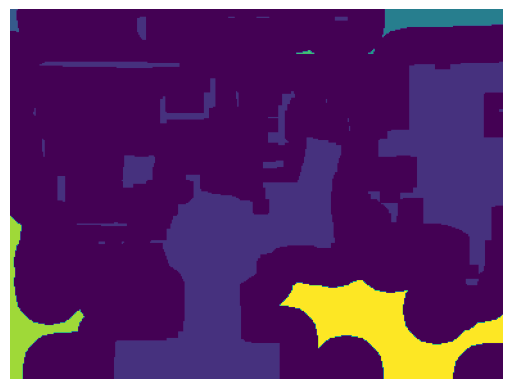

In [48]:
#Creating the marker image
ret, markers = cv.connectedComponents(np.uint8(sure_fg))

markers += 1

markers[unknown == 255] = 0

#printing the image
plt.imshow(markers)
plt.axis('off')
plt.show()

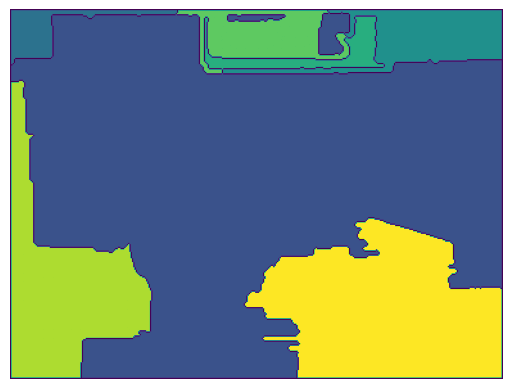

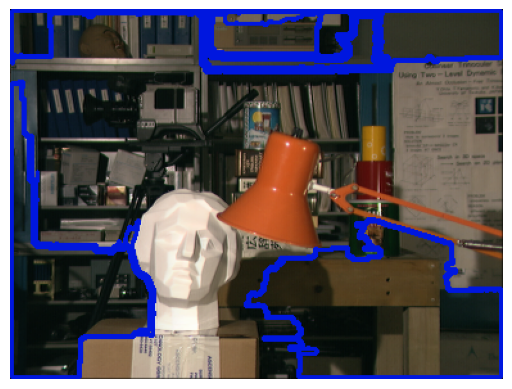

In [49]:
markers = cv.watershed(img, markers)

#printing the image
plt.imshow(markers)
plt.axis('off')
plt.show()

labels = np.unique(markers)

obj = []

for label in labels[2:]:

    target = np.where(markers == label, 255,0 ).astype(np.uint8)

    contours, hierarchy = cv.findContours(target, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    obj.append(contours[0])

RBSeg_img = cv.drawContours(img, obj, -1, color = (0,23,223), thickness = 2)


plt.imshow(RBSeg_img)
plt.axis('off')
plt.show()

# Part 4

The final goal is to obtain a depth map from a deep neural network and to apply the previous processes (segmentation and/or differential blur) to the resulting image.

You should test at least to different models for the state of the art. For example you can choose densedepth, MiDAS, etc.

## Densedepth

In [45]:
!pip install tensorflow
!pip install protobuf

/usr/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point
/usr/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point


In [49]:
!export PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python

In [51]:
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the model architecture
def create_depth_model(input_shape):
    model = models.Sequential()
    
    # Convolutional layers
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Upsampling layers
    model.add(layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    
    # Output layer
    model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
    
    return model

# Load the pre-trained model
input_shape = (256, 256, 3)  # Adjust input shape as per your images
model = create_depth_model(input_shape)
model.load_weights('depth_model_weights.h5')  # Load pre-trained weights




# Predict depth map
depth_map = model.predict(np.expand_dims(imag, axis=0))[0]

# Display original image and predicted depth map
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(depth_map.squeeze(), cmap='gray')
plt.title('Predicted Depth Map')
plt.axis('off')

plt.show()



TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

## Midas

In [52]:
!pip install transformers

/usr/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point
     |████████████████████████████████| 9.0 MB 3.0 MB/s eta 0:00:01     |██                              | 563 kB 3.0 MB/s eta 0:00:03
     |████████████████████████████████| 401 kB 33.6 MB/s eta 0:00:01
     |████████████████████████████████| 776 kB 11.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.6 MB 28.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 37.6 MB/s eta 0:00:01


In [53]:
import torch
from torchvision import transforms
from transformers import MidasNet
import cv2 as cv
import matplotlib.pyplot as plt

# Load the pre-trained Midas model
midas_model = MidasNet("vitb16")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas_model.to(device)

# Define the transformation for the input image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((384, 384)),  # Resize to match MidasNet input size
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# Resize to match MidasNet input size
image_resized = cv.resize(img, (384, 384))  
image_tensor = transform(image_resized).unsqueeze(0).to(device)

# Generate the depth map
with torch.no_grad():
    depth_map = midas_model.forward(image_tensor)

# Normalize the depth map
depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
depth_map_np = depth_map.squeeze().cpu().numpy()  # Convert to numpy array

# Display the depth map using matplotlib.pyplot
plt.imshow(depth_map_np, cmap='gray')
plt.axis('off')
plt.show()


/home/arevalinchy/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'MidasNet' from 'transformers' (/home/arevalinchy/.local/lib/python3.8/site-packages/transformers/__init__.py)

## Implementig the segmentations with the depthmap

### Pixel Based

In [ ]:
#Making the segmentation

#We create the foreground and the background regions
foreground = (depth_map >= 90)
background = (depth_map < 90)
#We make use of a zeroes matrix to build our new image, the segmented one.
segmentd_img = np.zeros((imgL.shape[0],imgL.shape[1],3))
segmentd_img[foreground ] = (1,1,1) #white in float
segmentd_img[background ] = (0,0,0) #black in float

#printing the image
plt.imshow(segmentd_img)
plt.axis('off')
plt.show()

### Edge Based

In [ ]:
blrImg = cv.GaussianBlur(depth_map, (3,3), sigmaX = 0, sigmaY = 0) 
#Implementing Canny
edgeCanny = cv.Canny(image = blrImg, threshold1=100, threshold2=200)

plt.imshow(edgeCanny )
plt.axis('off')
plt.show()


### Region Based

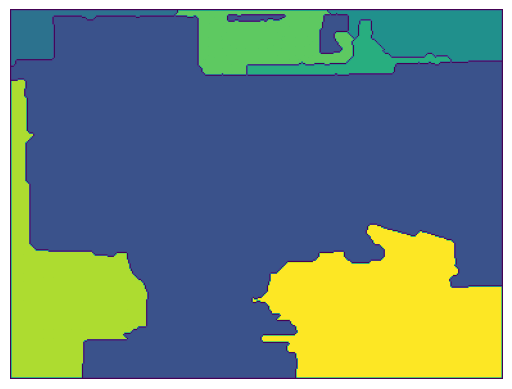

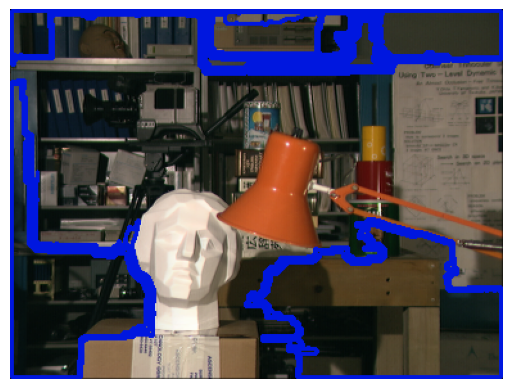

In [55]:
ret, bin_img = cv.threshold(depth_map,
                             0, 255, 
                             cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
bin_image = cv.morphologyEx(bin_img, cv.MORPH_OPEN, kernel, iterations = 2)

#Taking the background, the foreground, distance & the "unknown"

sure_bg = cv.dilate(bin_image, kernel, iterations=3)
dist = cv.distanceTransform(bin_image, cv.DIST_L2, 5)

ret, sure_fg = cv.threshold(dist, 0.5 * dist.max(), 255, cv.THRESH_BINARY)

fsure_fg = np.asarray(sure_fg, np.float64)
fsure_bg = np.asarray(sure_bg, np.float64)
unknown = cv.subtract(fsure_bg, fsure_fg)

#Creating the marker image
ret, markers = cv.connectedComponents(np.uint8(sure_fg))

markers += 1

markers[unknown == 255] = 0

markers = cv.watershed(img, markers)

#printing the image
plt.imshow(markers)
plt.axis('off')
plt.show()

labels = np.unique(markers)

obj = []

for label in labels[2:]:

    target = np.where(markers == label, 255,0 ).astype(np.uint8)

    contours, hierarchy = cv.findContours(target, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    obj.append(contours[0])

RBSeg_img = cv.drawContours(img, obj, -1, color = (0,23,223), thickness = 2)


plt.imshow(RBSeg_img)
plt.axis('off')
plt.show()

# Github for de deep neural network repositories

https://github.com/pranjaldatta/DenseDepth-Pytorch
https://github.com/isl-org/MiDaS&ved=2ahUKEwiakdGlypCGAxU5CRAIHTETAQwQFnoECBUQAQ&usg=AOvVaw2LAzMC7YR7Zaclv5_EuVNX

# Every link that helps me survive the long and awaited development of the C.V. project >;)

https://learnopencv.com/depth-perception-using-stereo-camera-python-c/
https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html?highlight=filterspeckles#cv2.filterSpeckles
https://python.plainenglish.io/the-depth-ii-block-matching-d599e9372712
https://docs.opencv.org/3.4/d9/dba/classcv_1_1StereoBM.html
https://docs.opencv.org/3.4/dd/d53/tutorial_py_depthmap.html
https://docs.opencv.org/4.x/db/deb/tutorial_display_image.html

https://www.tutorialspoint.com/splitting-and-merging-channels-with-opencv-python
https://docs.opencv.org/4.x/d3/d50/group__imgproc__colormap.html
https://docs.opencv.org/4.x/d3/d47/group__imgproc__segmentation.html
https://docs.opencv.org/4.x/d8/d01/group__imgproc__color__conversions.html
https://matplotlib.org/stable/users/explain/colors/colormaps.
https://www.geeksforgeeks.org/how-to-display-multiple-images-in-one-figure-correctly-in-matplotlib/
https://www.statology.org/fig-add-subplot/
https://stackoverflow.com/questions/42675864/how-to-remove-gaps-between-image-subplots

http://wiki.ros.org/stereo_image_proc/Tutorials/ChoosingGoodStereoParameters

https://readthedocs.org/projects/opencv24-python-tutorials/downloads/pdf/latest/

https://medium.com/@mamchinn/unleashing-the-potential-of-histogram-segmentation-for-image-segmentation-d3fe92a1db25
https://docs.opencv.org/4.x/d1/db7/tutorial_py_histogram_begins.html
https://en.wikipedia.org/wiki/Watershed_(image_processing)
https://www.geeksforgeeks.org/image-segmentation-with-watershed-algorithm-opencv-python/?ref=lbp

https://www.geeksforgeeks.org/region-and-edge-based-segmentaion/
https://cloudinary.com/glossary/edge-based-segmentation
http://engr.case.edu/merat_francis/EEAP%20431%20S97/Lecture%20Notes/10_Edge%20Segmentation.pdf

https://www.datacamp.com/tutorial/introduction-to-deep-neural-networks&ved=2ahUKEwjlmpXOioOGAxUuVfEDHfAWDh4QFnoECCkQAQ&usg=AOvVaw3-Gx7hGzTgL6oK3qV1X_VV

https://github.com/pranjaldatta/DenseDepth-Pytorch
https://arxiv.org/abs/1812.11941
https://github.com/ialhashim/DenseDepth?tab=readme-ov-file
https://github.com/ialhashim/DenseDepth/blob/master/DenseDepth.ipynb